Apartment Pricing Model
Based on the data set containing listings of apartments offered for sale in various regions of Russia I develop a pricing models that could be used to evaluate apartments located in the city of Saint Petersburg. Similar approach could be used to create regression models for other regions.

Models used: XGBoost, LGBM, CatBoost

Techniques applied: data cleaning, filtering outliers, feature engineering

In [17]:
import gc
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [46]:
PATH = '/Users/artem/Documents/Projects/CIAN Real Estate/cian-sales-2018-2021.csv'
df = pd.read_csv(PATH)
print(f'Data shape: {df.shape}')
df.head()

Data shape: (5477006, 13)


,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,20:00:21,59.8058,30.3761,2661,1,8,10,3,82.6000,10.8000,1
1,8650000,2018-02-27,12:04:54,55.6838,37.2974,81,3,5,24,2,69.1000,12.0000,1
2,4000000,2018-02-28,15:44:00,56.2953,44.0616,2871,1,5,9,3,66.0000,10.0000,1
3,1850000,2018-03-01,11:24:52,44.9961,39.0748,2843,4,12,16,2,38.0000,5.0000,11
4,5450000,2018-03-01,17:42:43,55.9188,37.9846,81,3,13,14,2,60.0000,10.0000,1


In [47]:
df.isna().sum()

price            0
date             0
time             0
geo_lat          0
geo_lon          0
region           0
building_type    0
level            0
levels           0
rooms            0
area             0
kitchen_area     0
object_type      0
dtype: int64

In [21]:
df.describe()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
count,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06,5.477006e+06
mean,4.422029e+06,5.403826e+01,5.324433e+01,4.307141e+03,1.948966e+00,6.214530e+00,1.139892e+01,1.726173e+00,5.391825e+01,1.062840e+01,3.945399e+00
std,2.150752e+07,4.622758e+00,2.074763e+01,3.308050e+03,1.038537e+00,4.957419e+00,6.535734e+00,1.082133e+00,3.335293e+01,9.792380e+00,4.558357e+00
min,-2.144967e+09,4.145906e+01,1.989020e+01,3.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-2.000000e+00,7.000000e-02,1.000000e-02,1.000000e+00
25%,1.950000e+06,5.337768e+01,3.777790e+01,2.661000e+03,1.000000e+00,2.000000e+00,5.000000e+00,1.000000e+00,3.800000e+01,7.000000e+00,1.000000e+00
50%,2.990000e+06,5.517139e+01,4.306774e+01,2.922000e+03,2.000000e+00,5.000000e+00,1.000000e+01,2.000000e+00,4.802000e+01,9.700000e+00,1.000000e+00
75%,4.802000e+06,5.622613e+01,6.564895e+01,6.171000e+03,3.000000e+00,9.000000e+00,1.600000e+01,2.000000e+00,6.313000e+01,1.270000e+01,1.100000e+01
max,2.147484e+09,7.198040e+01,1.625361e+02,6.188800e+04,5.000000e+00,3.900000e+01,3.900000e+01,1.000000e+01,7.856000e+03,9.999000e+03,1.100000e+01


In [22]:
# Function sets display options for charts and pd.DataFrames.
def set_display():
    # Plots display settings
    plt.style.use('fivethirtyeight')
    plt.rcParams['figure.figsize'] = 12, 8
    plt.rcParams.update({'font.size': 14})
    # DataFrame display settings
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.options.display.float_format = '{:.4f}'.format

In [25]:
# add features
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    # Replace "date" with numeric features for year and month.
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df.drop('date', axis=1, inplace=True)
    # Apartment floor in relation to total number of floors.
    df['level_to_levels'] = df['level'] / df['levels']
    # Average size of room in the apartment.
    df['area_to_rooms'] = (df['area'] / df['rooms']).abs()
    # Fix division by zero.
    df.loc[df['area_to_rooms'] == np.inf, 'area_to_rooms'] = \
        df.loc[df['area_to_rooms'] == np.inf, 'area']
    return df

In [26]:
# Utility function to use for reproducibility.
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    # tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [27]:
# Data set contains samples with typos and errors including negative prices, 
# too large or unrealistically small floor area, etc. 
# Let's clean the data before proceeding with the analysis. 
# We limit the floor area to a range betwee 20 sq.m and 200 sq.m 
# and price to a range between 1.5 mln to 50 mln rubles, which covers most of the housing market.
df = df.pipe(clean_data)
df.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [28]:
df_real = df.copy()
df_real.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
1,8650000,2018-02-27,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2,4000000,2018-02-28,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
3,1850000,2018-03-01,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
4,5450000,2018-03-01,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [29]:
# Decode building type and object type 
df_real['building_type']= df_real['building_type'].replace([0,1,2,3,4,5],['Other','Panel','Monolithic','Brick','Blocky','Wooden'])
df_real['object_type']= df_real['object_type'].replace([1,11],['Secondary Real Estate','New Building'])
df_real.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,59.805808,30.376141,2661,Panel,8,10,3,82.6,10.8,Secondary Real Estate
1,8650000,2018-02-27,55.683807,37.297405,81,Brick,5,24,2,69.1,12.0,Secondary Real Estate
2,4000000,2018-02-28,56.295250,44.061637,2871,Panel,5,9,3,66.0,10.0,Secondary Real Estate
3,1850000,2018-03-01,44.996132,39.074783,2843,Blocky,12,16,2,38.0,5.0,New Building
4,5450000,2018-03-01,55.918767,37.984642,81,Brick,13,14,2,60.0,10.0,Secondary Real Estate


In [30]:
# convert to datetime
df_real['date'] = pd.to_datetime(df_real['date'])
df_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4747486 entries, 0 to 5477005
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   price          int64         
 1   date           datetime64[ns]
 2   geo_lat        float64       
 3   geo_lon        float64       
 4   region         int64         
 5   building_type  object        
 6   level          int64         
 7   levels         int64         
 8   rooms          int64         
 9   area           float64       
 10  kitchen_area   float64       
 11  object_type    object        
dtypes: datetime64[ns](1), float64(4), int64(5), object(2)
memory usage: 470.9+ MB


In [31]:
df_real['region'] = df_real['region'].astype(str)
df_real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4747486 entries, 0 to 5477005
Data columns (total 12 columns):
 #   Column         Dtype         
---  ------         -----         
 0   price          int64         
 1   date           datetime64[ns]
 2   geo_lat        float64       
 3   geo_lon        float64       
 4   region         object        
 5   building_type  object        
 6   level          int64         
 7   levels         int64         
 8   rooms          int64         
 9   area           float64       
 10  kitchen_area   float64       
 11  object_type    object        
dtypes: datetime64[ns](1), float64(4), int64(4), object(3)
memory usage: 470.9+ MB


In [32]:
# convert prices to Millions
df_real['price']=df_real['price']/1000000
df_real.head()

,price,date,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6.05,2018-02-19,59.805808,30.376141,2661,Panel,8,10,3,82.6,10.8,Secondary Real Estate
1,8.65,2018-02-27,55.683807,37.297405,81,Brick,5,24,2,69.1,12.0,Secondary Real Estate
2,4.00,2018-02-28,56.295250,44.061637,2871,Panel,5,9,3,66.0,10.0,Secondary Real Estate
3,1.85,2018-03-01,44.996132,39.074783,2843,Blocky,12,16,2,38.0,5.0,New Building
4,5.45,2018-03-01,55.918767,37.984642,81,Brick,13,14,2,60.0,10.0,Secondary Real Estate


In [33]:
set_display()

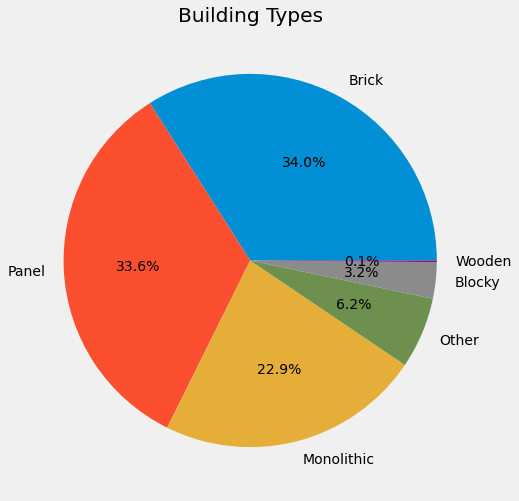

In [34]:
# building types proportion
building_types = df_real['building_type'].value_counts()
plt.pie(building_types.values, labels=building_types.index, autopct='%1.1f%%')
plt.title('Building Types')
plt.show()

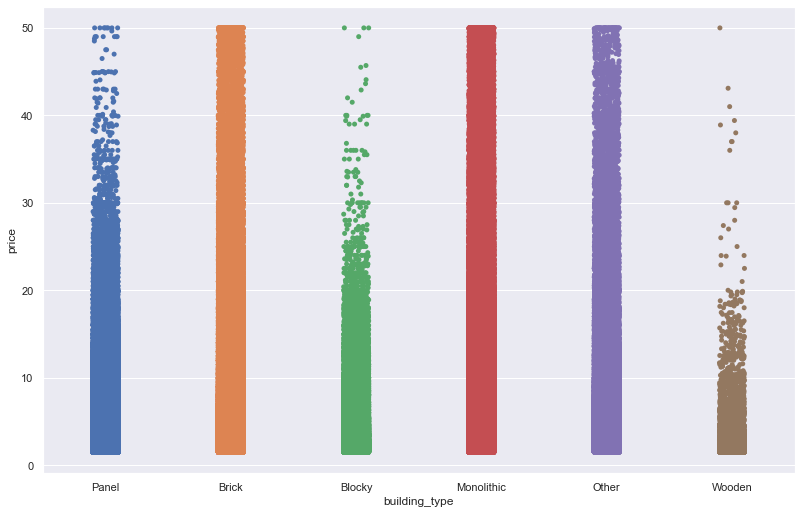

In [35]:
sns.set()
sns.stripplot(x='building_type',y='price',data=df_real)
plt.show()

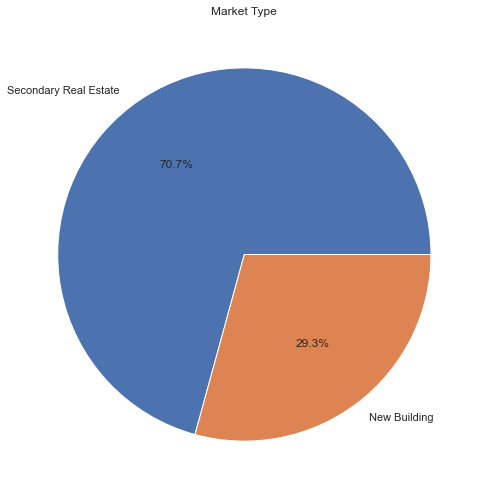

In [36]:
# market type proportion
market_type = df_real['object_type'].value_counts()
plt.pie(market_type.values, labels=market_type.index, autopct='%1.1f%%')
plt.title('Market Type')
plt.show()

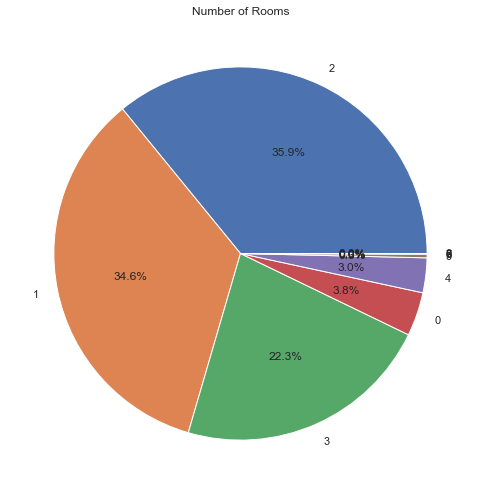

In [37]:
# number of rooms proportion
rooms = df_real['rooms'].value_counts()
plt.pie(rooms.values, labels=rooms.index, autopct='%1.1f%%')
plt.title('Number of Rooms')
plt.show()

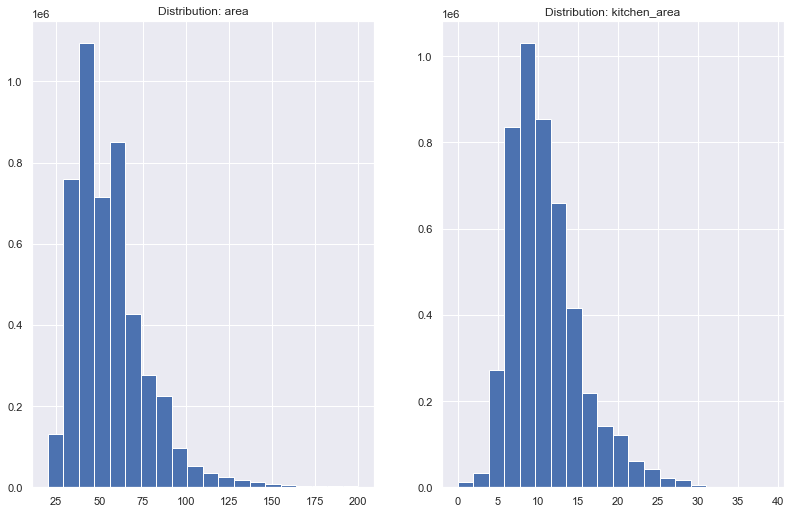

In [38]:
pos = 0
for pos, feature in enumerate(['area', 'kitchen_area']):
    sp = plt.subplot(1, 2, pos + 1)
    plt.hist(df_real[feature], bins=20)
    plt.title(f'Distribution: {feature}')
plt.show()

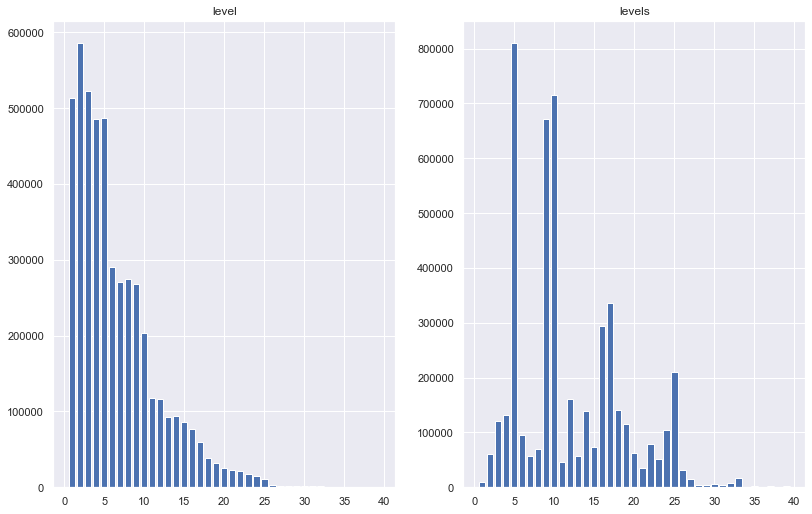

In [39]:
# levels distribution
pos = 0
for pos, feature in enumerate(['level', 'levels']):
    levels = df_real[feature].value_counts()
    sp = plt.subplot(1, 2, pos + 1)
    plt.bar(levels.index, levels.values)
    plt.title(feature)
plt.show()

9654    812372
2843    575693
81      480497
2661    453621
3       411225
2922    213368
6171    205363
3230    196428
3991    132777
5282    103757
Name: region, dtype: int64


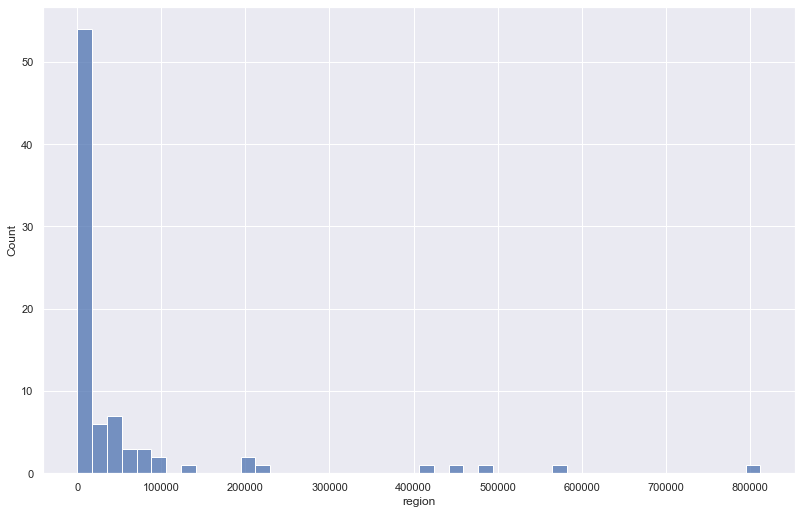

In [40]:
# Regions are encoded with numeric IDs.
regions = df_real['region'].value_counts()
print(regions.head(10))
# Listings are unequally distributed between the regions with most of the offerings 
# concentrated in the largest and most developed cities and their surrounding areas
sns.histplot(regions)
plt.show()

In [41]:
# Find out what regions are represented in the data set.
for region in df_real['region'].unique():
    subset = df_real[df_real['region'] == region]
    lat, lon = np.round(subset[['geo_lat', 'geo_lon']].mean(), 2)
    print(f'Region {region}: latitude = {lat}, longitude = {lon}')

Region 2661: latitude = 59.93, longitude = 30.32
Region 81: latitude = 55.73, longitude = 37.77
Region 2871: latitude = 56.24, longitude = 43.91
Region 2843: latitude = 44.86, longitude = 38.88
Region 3: latitude = 55.72, longitude = 37.58
Region 3106: latitude = 53.25, longitude = 50.08
Region 2922: latitude = 55.75, longitude = 49.91
Region 2722: latitude = 54.61, longitude = 55.76
Region 3230: latitude = 47.27, longitude = 39.73
Region 4417: latitude = 62.41, longitude = 51.94
Region 5282: latitude = 55.08, longitude = 61.2
Region 5368: latitude = 53.14, longitude = 103.66
Region 3446: latitude = 59.99, longitude = 30.41
Region 5520: latitude = 58.03, longitude = 56.19
Region 6171: latitude = 56.88, longitude = 60.6
Region 9579: latitude = 51.92, longitude = 107.65
Region 1010: latitude = 56.91, longitude = 53.26
Region 9648: latitude = 43.5, longitude = 43.61
Region 2604: latitude = 57.62, longitude = 39.77
Region 3019: latitude = 56.11, longitude = 47.27
Region 4982: latitude = 56

In [42]:
avg_prices = df_real.groupby(by='region')['price'].mean()
avg_prices = avg_prices.sort_values(ascending=False)
avg_prices

region
3       11.4597
2661     7.6635
7873     5.6006
6937     5.1607
81       4.8643
7896     4.7817
7929     4.7438
61888    4.4250
2484     4.3201
14880    4.2631
4086     4.2607
3446     4.0656
1901     4.0471
6543     3.9403
3991     3.9053
2871     3.8523
2922     3.7959
5178     3.7508
6171     3.7369
2843     3.7042
10201    3.5402
11171    3.4928
2328     3.4393
5952     3.4117
5143     3.3966
16705    3.3836
13098    3.3713
10582    3.3069
3870     3.2783
2722     3.2430
8640     3.1721
4007     3.1704
10160    3.1228
3106     3.0959
4695     3.0655
2885     3.0542
9654     3.0513
2072     3.0367
5993     3.0050
5368     3.0043
1491     3.0005
5520     2.9775
7121     2.9766
4963     2.9670
3230     2.9629
4189     2.9401
2594     2.9354
2814     2.8735
2604     2.8500
13919    2.8403
4240     2.8135
2900     2.8036
9579     2.7989
4417     2.7979
821      2.7929
9648     2.7862
5789     2.7859
14368    2.7858
4374     2.7809
2806     2.7603
11991    2.7532
8090     2.7406
4

Knowing the basics of real estate pricing, it's unreasonable to develop a single model for all the regions. Pricing factors could have different impact on the actual price depending on the region, local market conditions, prevailing types of buildings in the area, etc.

A number of important features are missing in this data set, which would lead to larger errors regardless of applied regression algorithms and quality of the model:

Condition: similar apartments would be priced differently, if one of them is being sold fully furnished in excellent condition and the other is being sold without finishing.
Ceiling height affects the price.
Balconies and terraces increase the price compared to similar apartments without such menities.
Additional unique properties usually mentioned in the description of the apartment, like chimneys or underground parking spaces, affect the price.
Taking that in mind we will try to develop a pricing model for apartments located in Saint Petersburg.

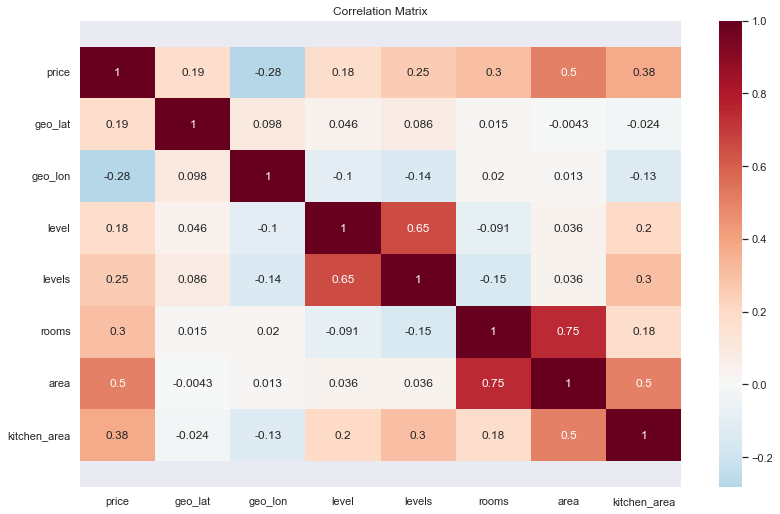

In [48]:
# correlation matrix
correlation = df_real.corr()
ax = sns.heatmap(correlation, center=0, cmap='RdBu_r', annot=True)
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.show()